In [1]:
import pandas as pd  
import numpy as np
from IPython.display import clear_output
from pathlib import Path
from ast import literal_eval
import seaborn as sns
import matplotlib.pyplot as plt

# Utils

In [2]:
def sliding_window(image_size: tuple, overlap: float, windowSize: tuple):
    """
    Slide a window across the image.

    Parameters
    ----------
    image_size : tuple
        Size of the image in pixels, in the format (height, width)
    overlap : float
        The proportion of overlap between windows
    windowSize : tuple
        Size of the window in pixels, in the format (height, width)

    Yields
    ------
    tuple
        The coordinates of the current window, in the format (x1, y1, x2, y2)

    """
    # Calculate the number of steps needed in each dimension
    num_steps_y = int(np.ceil((image_size[0] - windowSize[0]) / (windowSize[0] * (1 - overlap))) + 1)
    num_steps_x = int(np.ceil((image_size[1] - windowSize[1]) / (windowSize[1] * (1 - overlap))) + 1)
    
    # Generate the starting coordinates for the y-axis and x-axis
    y_steps = np.linspace(0, image_size[0] - windowSize[0], num_steps_y).astype(int)
    x_steps = np.linspace(0, image_size[1] - windowSize[1], num_steps_x).astype(int)
    
    for y in y_steps:
        for x in x_steps:
            # yield the current window, just the coords:
            yield (x, y, x + windowSize[1], y + windowSize[0])
def get_additional_not_events(subfolder_name):
    """
    Returns the number of additional not events for a given subfolder name.

    Parameters
    ----------
    subfolder_name: str
        The name of the subfolder

    Returns
    -------
    additional_not_events: int
        The number of additional not events
    """
    image_size = (1400,1400)
    windowSize = literal_eval(subfolder_name.split('_')[-1])
    overlap = literal_eval(subfolder_name.split('_')[-3])

    windows = list(sliding_window(image_size, overlap, windowSize))
    additional_not_events = count_not_events_granules * len(windows)
    return additional_not_events

# function that lists all the csv in a folder:
def list_csv(path):
    """Returns a list of csv files in the given path.

    :param path: path to look for csv files
    :type path: str or Path

    :return: list of csv files
    :rtype: list of Path
    """
    path = Path(path)
    csv_files = [x for x in path.iterdir() if x.is_file() and x.suffix == '.csv']
    return csv_files

# function that lists all the subfolder of a folder:
def list_subfolder(path):
    """
    List subfolders of a given path.

    Args:
        path: Path to a folder.

    Returns:
        List of subfolders.

    """
    path = Path(path)
    subfolders = [x for x in path.iterdir() if x.is_dir()]
    return subfolders

# write function that conncats all the csv files in a folder:
def concat_csv(path):
    """Concatenates all the csv files in a given path.

    :param path: path to look for csv files
    :type path: str or Path

    :return: concatenated dataframe
    :rtype: pandas.DataFrame
    """
    path = Path(path)
    csv_files = list_csv(path)
    df = pd.concat([pd.read_csv(x, index_col=0) for x in csv_files])
    df.reset_index(drop=True, inplace=True)
    # order in the format: event, granule_idx, events, not_events:
    df = df[['event', 'granule_idx', 'events', 'not_events']]
    return df

# Study

In [4]:
ref_db = pd.read_csv('thraws_db.csv', index_col=0)
ref_db[ref_db['class'] == 'not_event'].reset_index(drop=True)

# 11 not events granules:
count_not_events_granules = 11

The number of events is:  852
The number of not events is:  2973


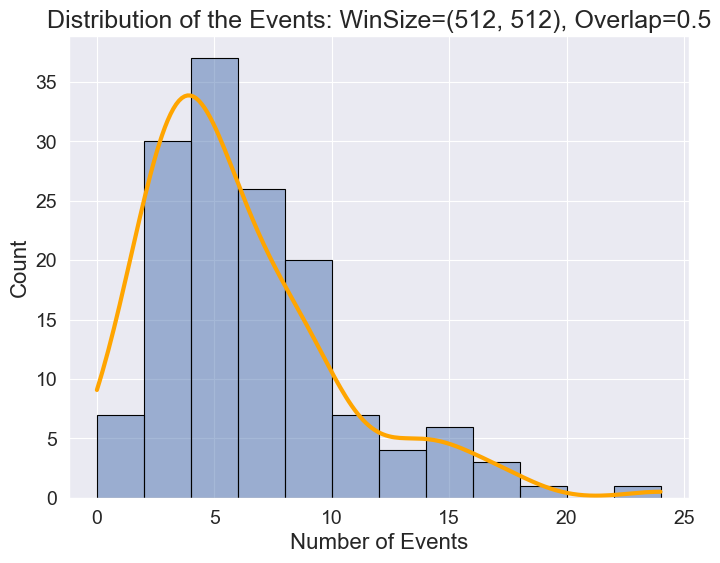

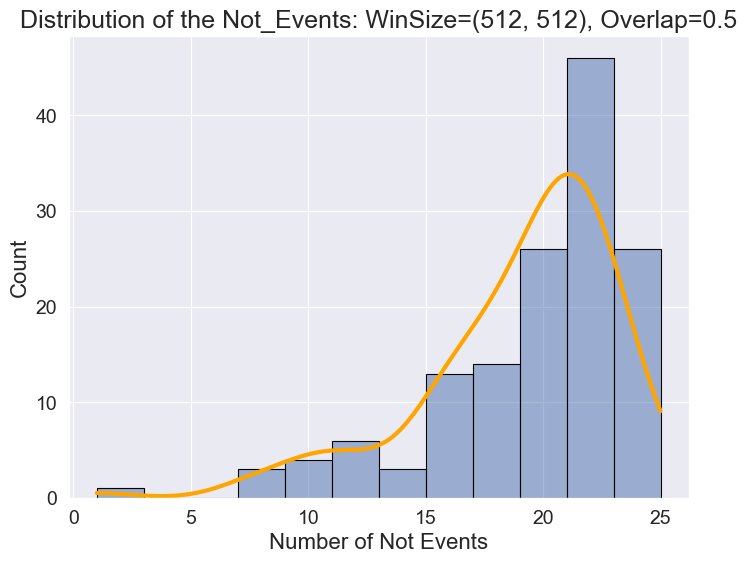

The number of events is:  8345
The number of not events is:  248848


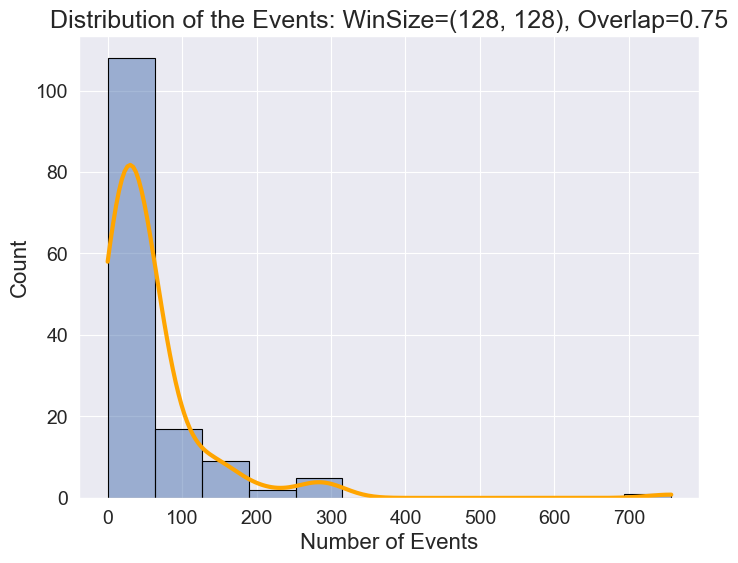

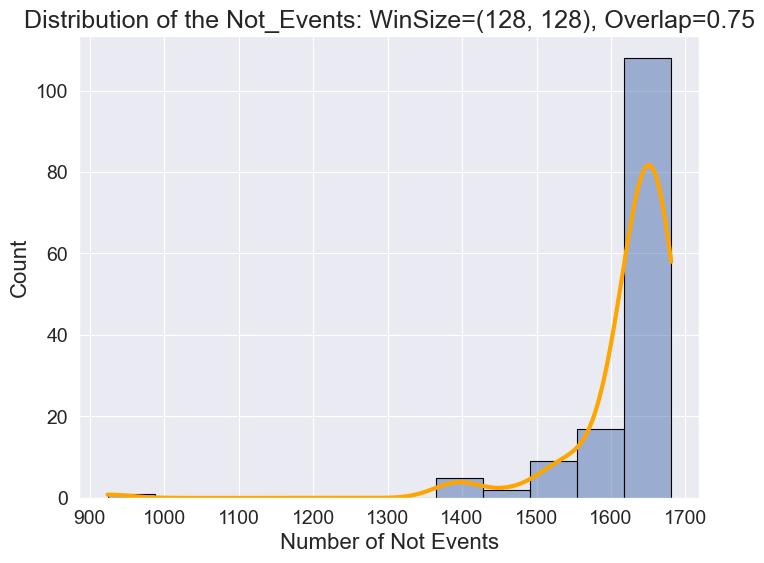

The number of events is:  1102
The number of not events is:  6395


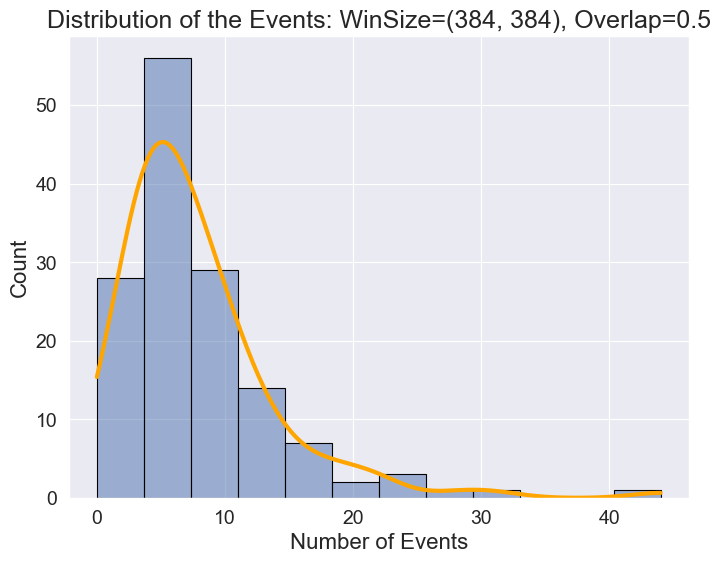

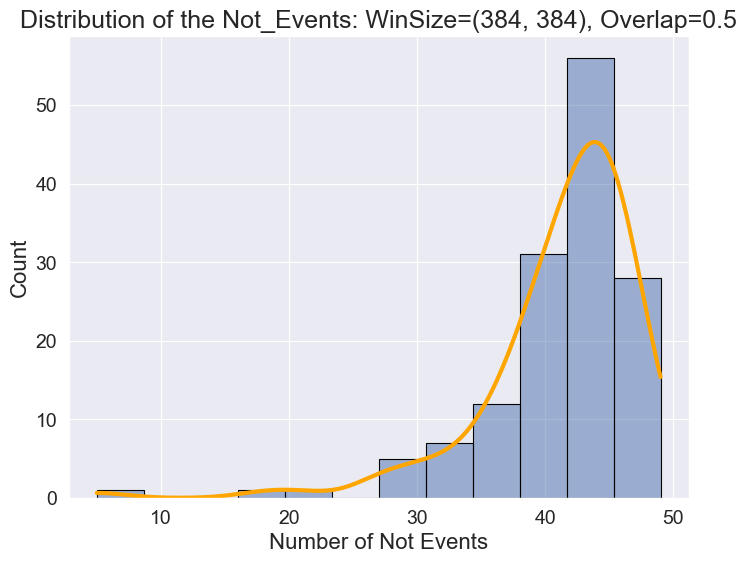

The number of events is:  1211
The number of not events is:  37957


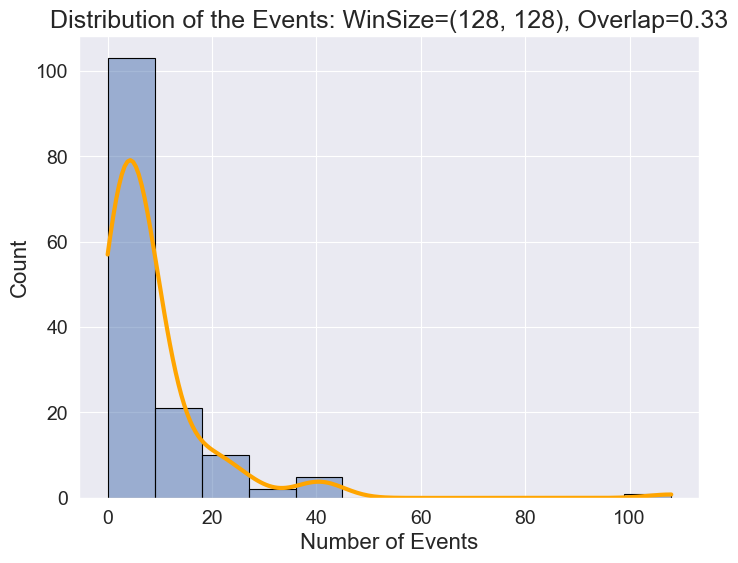

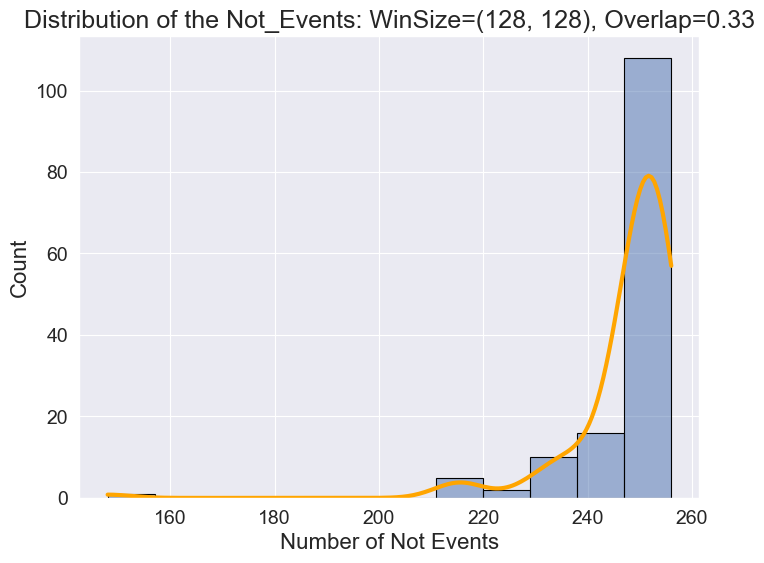

The number of events is:  1090
The number of not events is:  33335


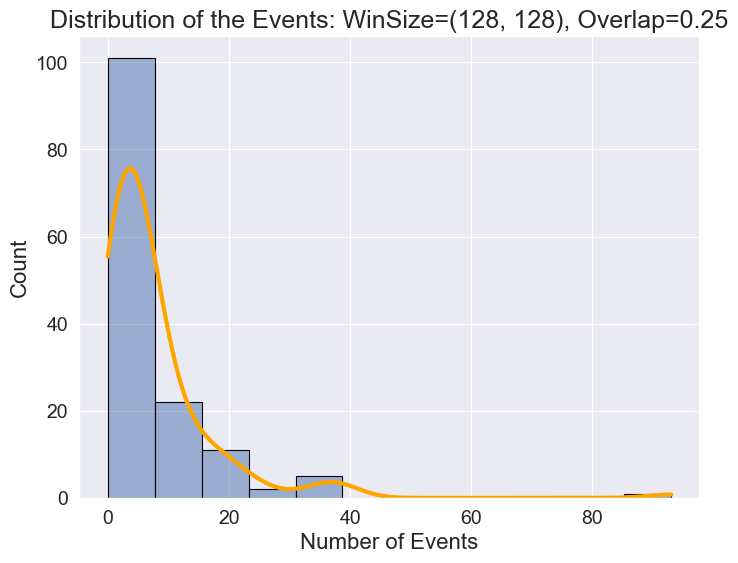

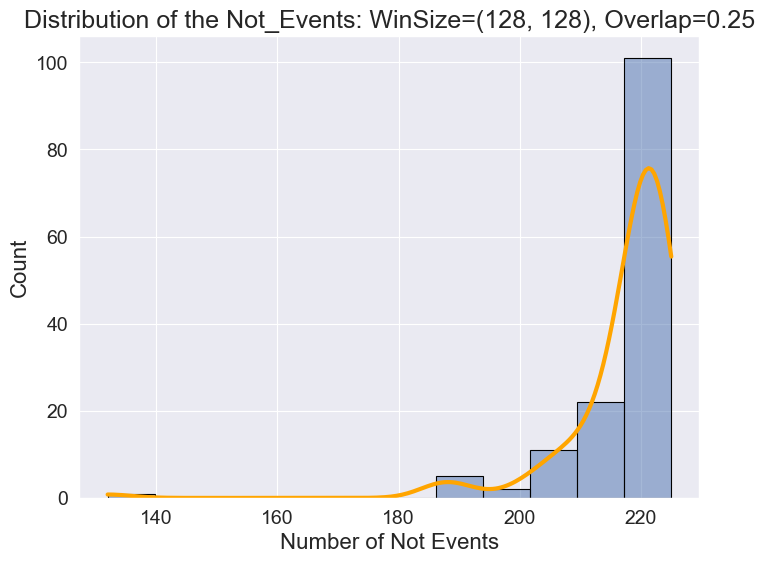

The number of events is:  1220
The number of not events is:  14080


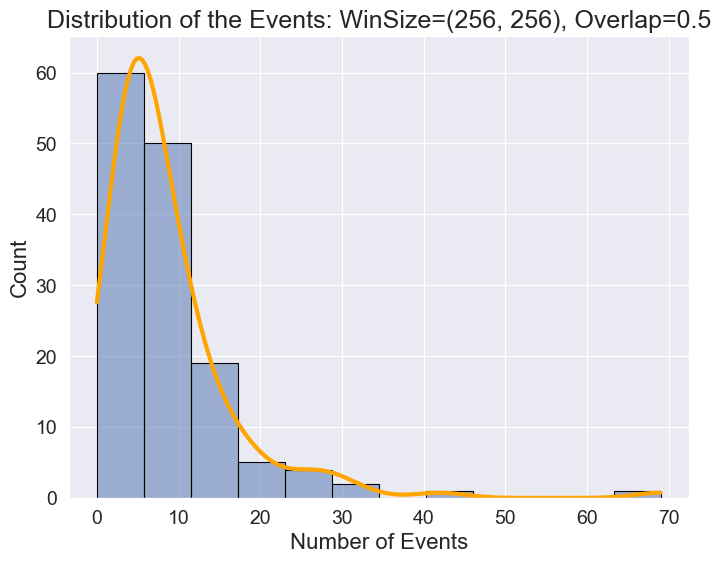

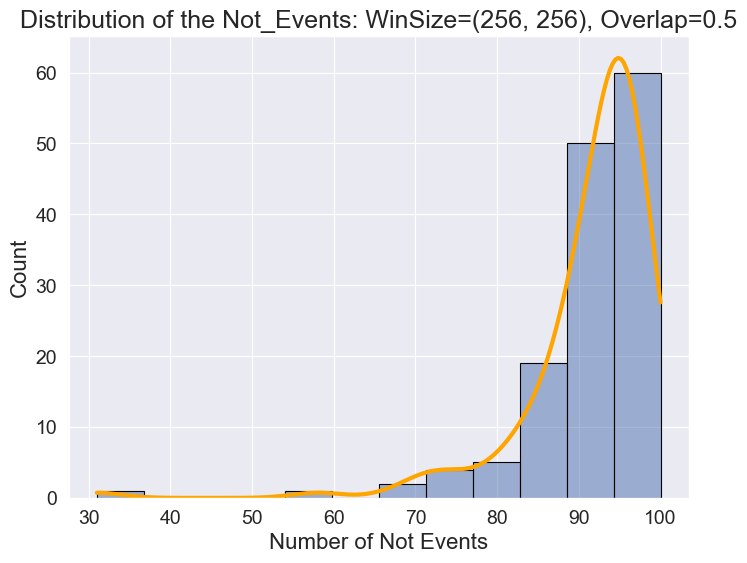

The number of events is:  4582
The number of not events is:  50651


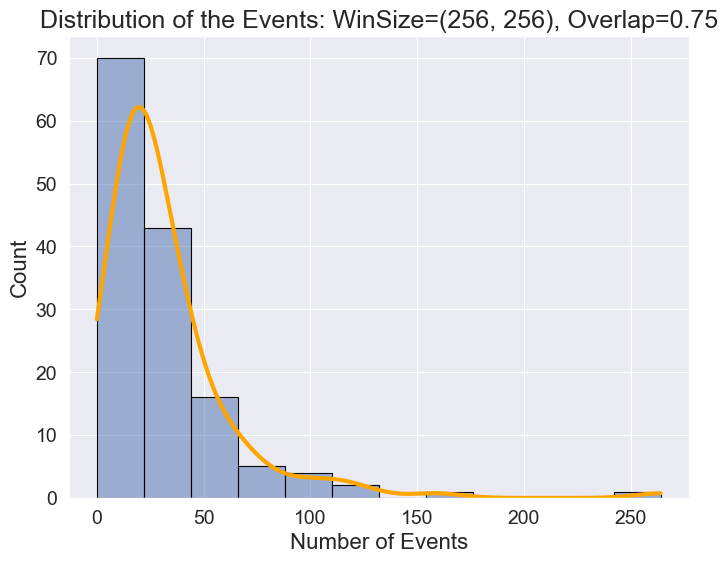

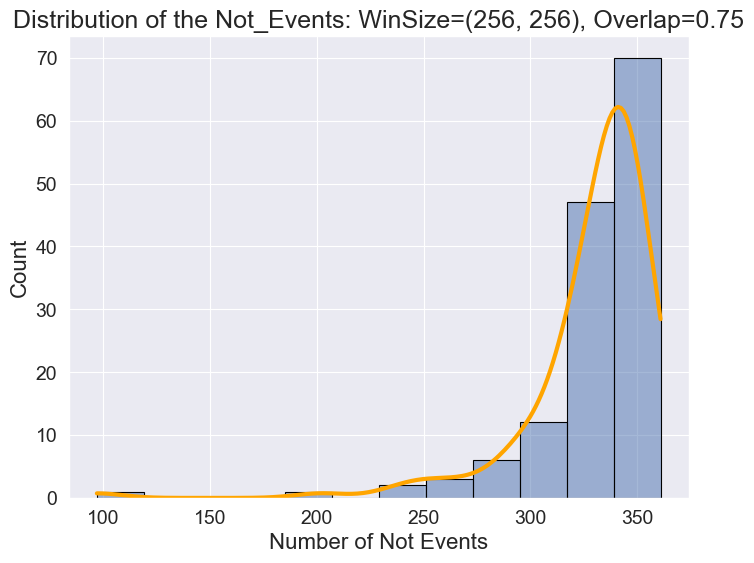

The number of events is:  541
The number of not events is:  1907


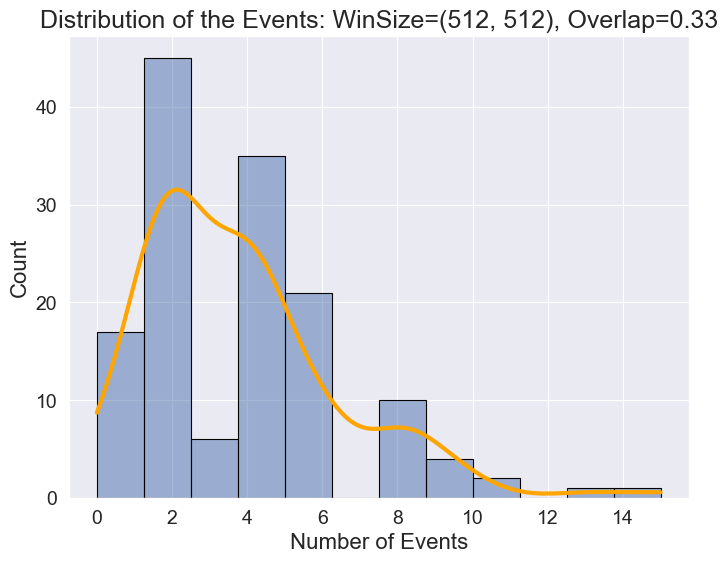

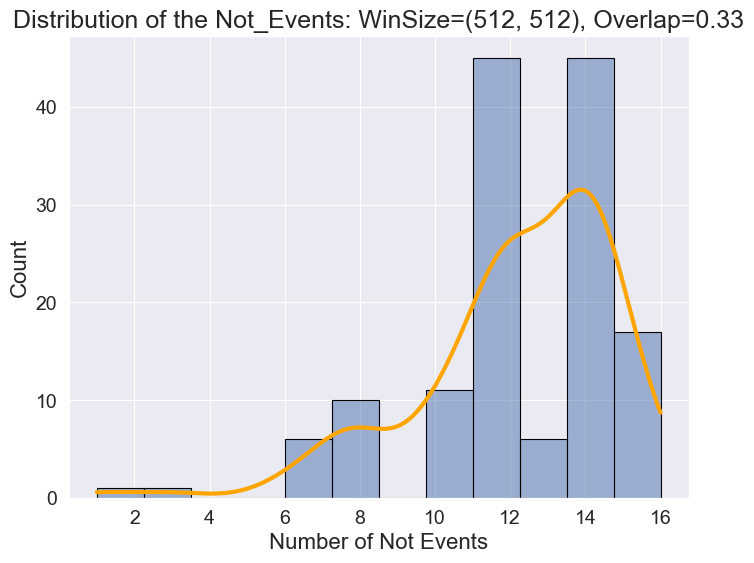

The number of events is:  541
The number of not events is:  1907


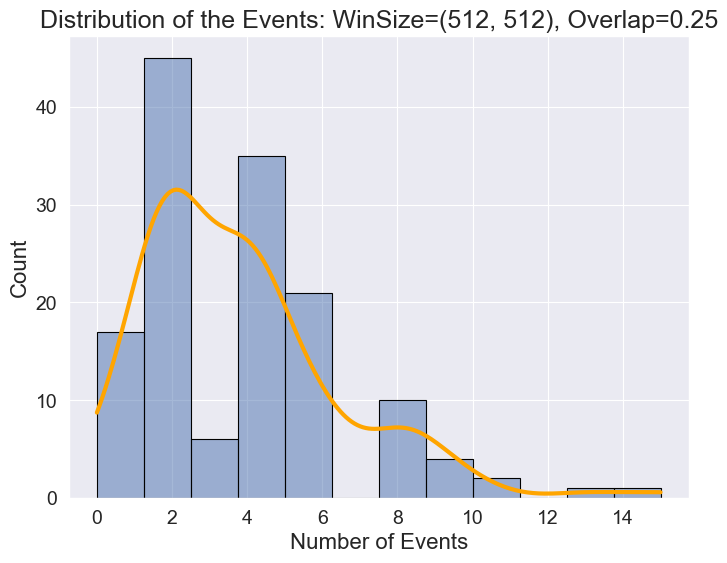

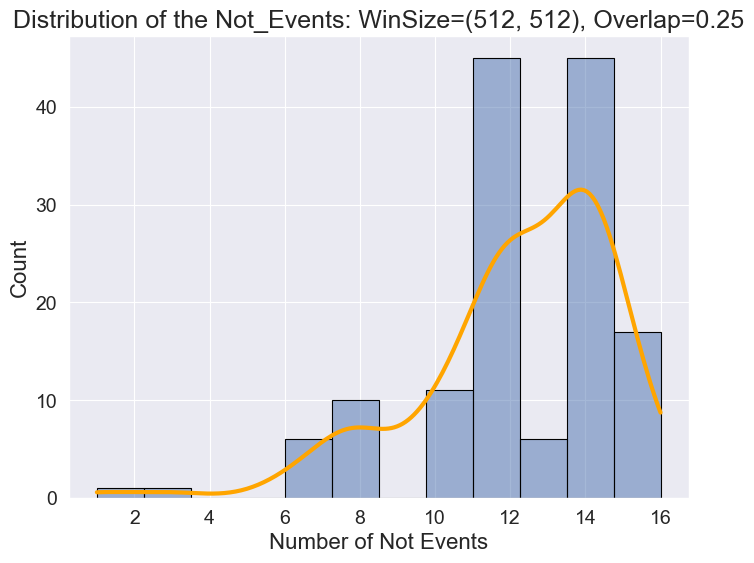

The number of events is:  3326
The number of not events is:  18706


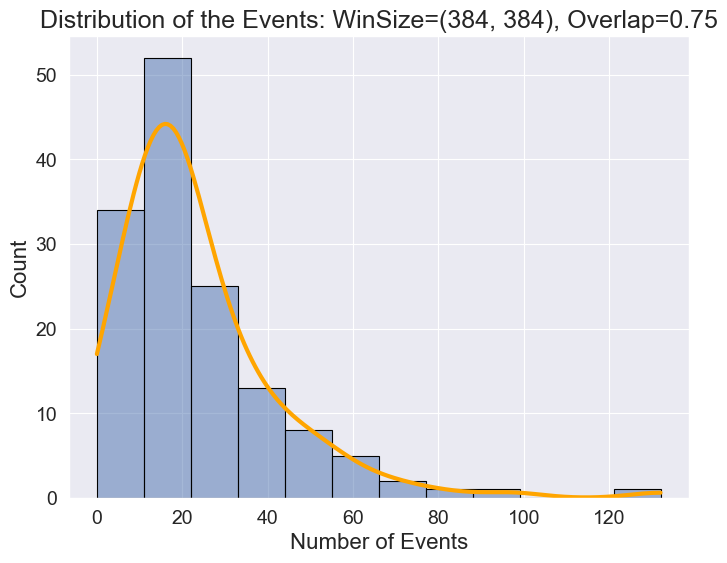

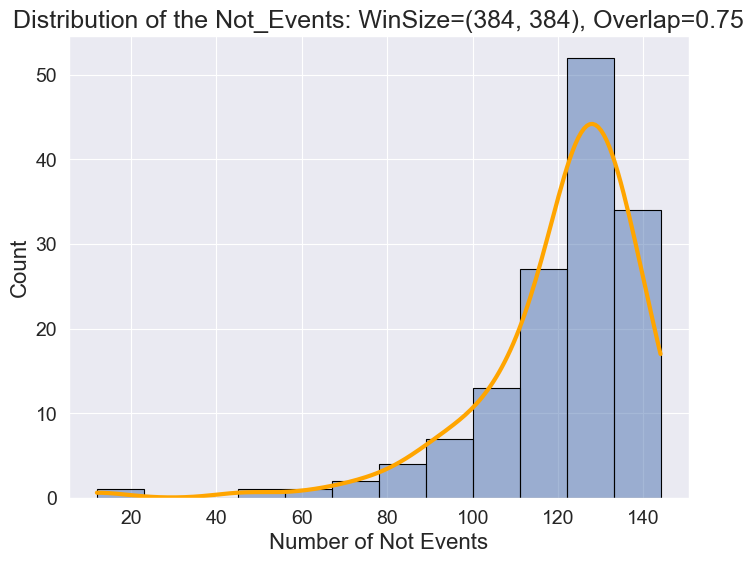

The number of events is:  2158
The number of not events is:  65315


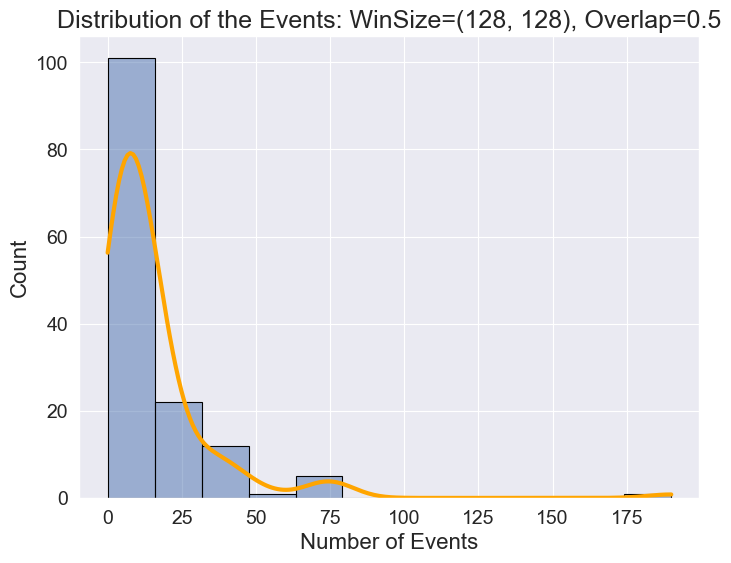

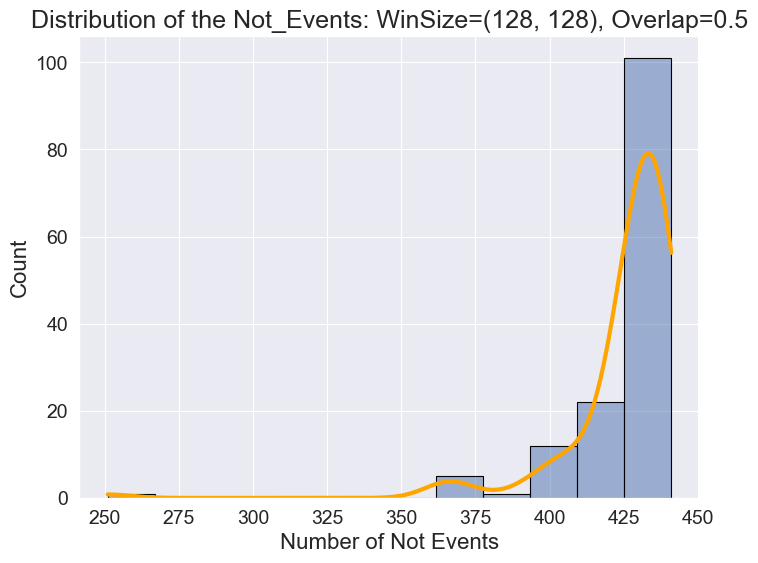

The number of events is:  2189
The number of not events is:  7603


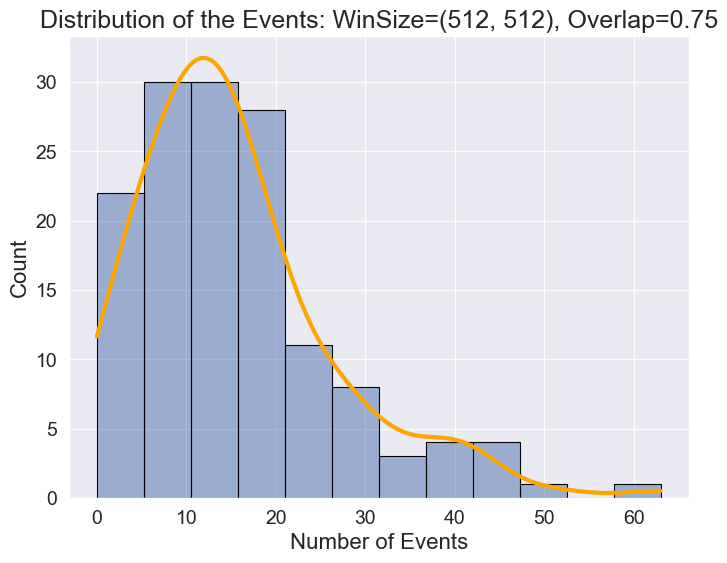

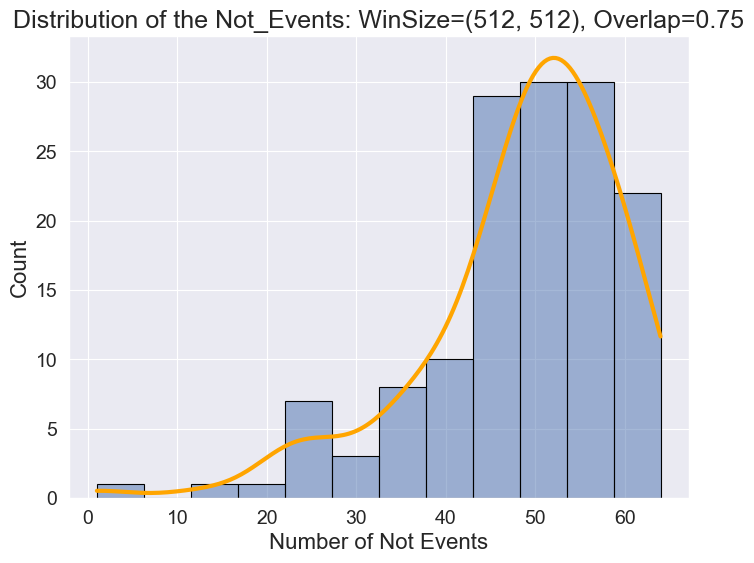

The number of events is:  783
The number of not events is:  9009


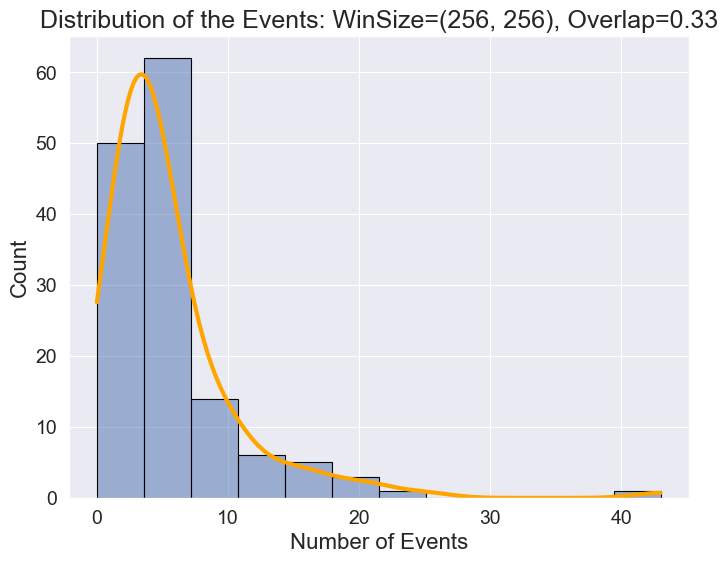

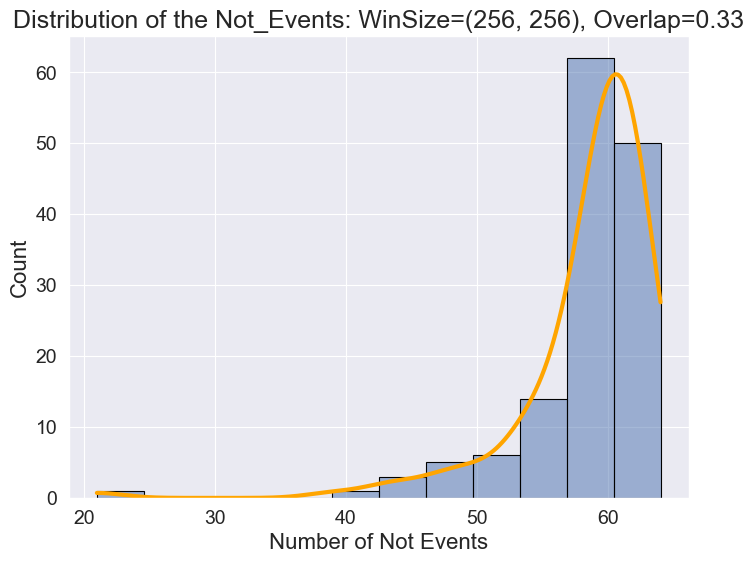

The number of events is:  581
The number of not events is:  6916


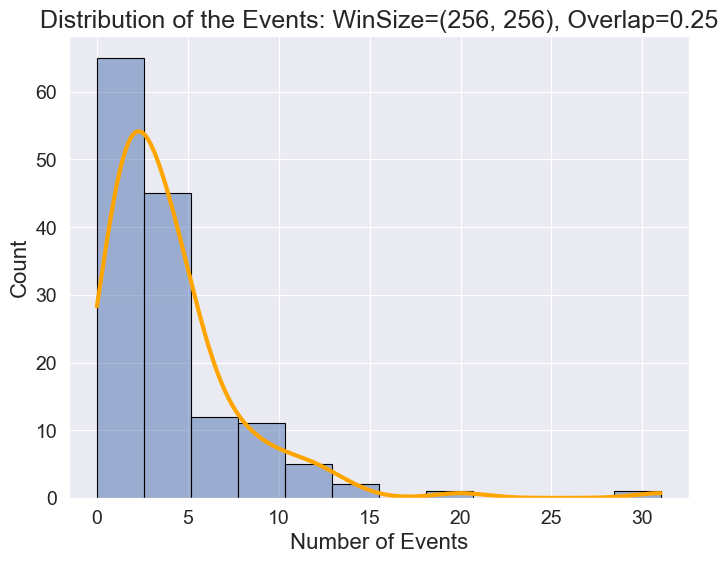

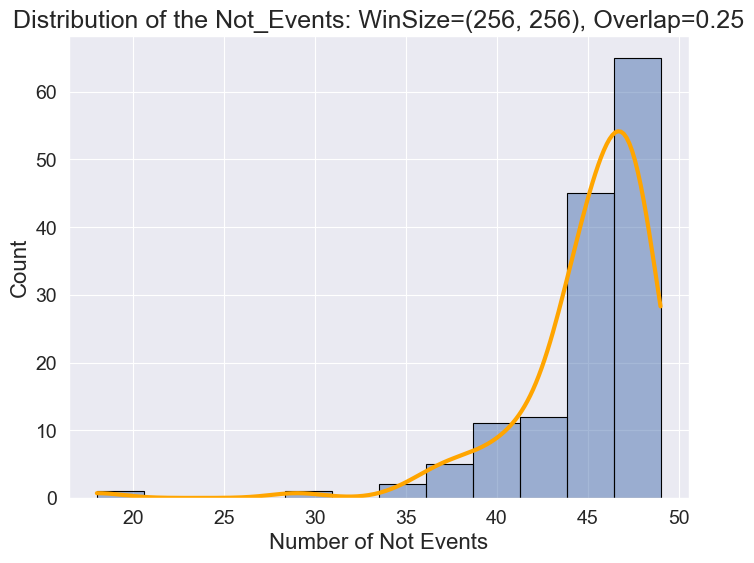

The number of events is:  527
The number of not events is:  3298


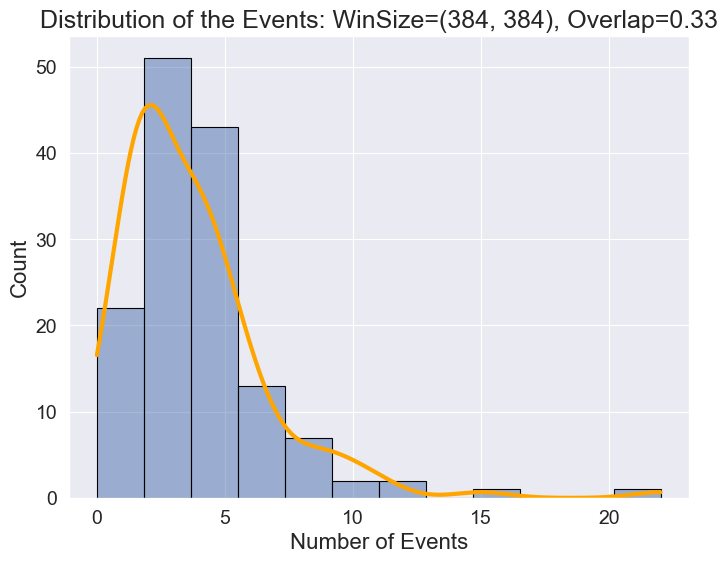

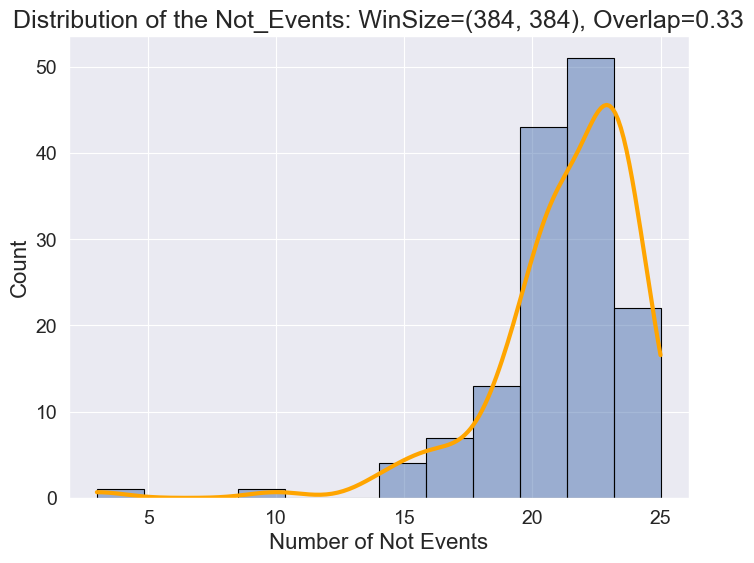

The number of events is:  527
The number of not events is:  3298


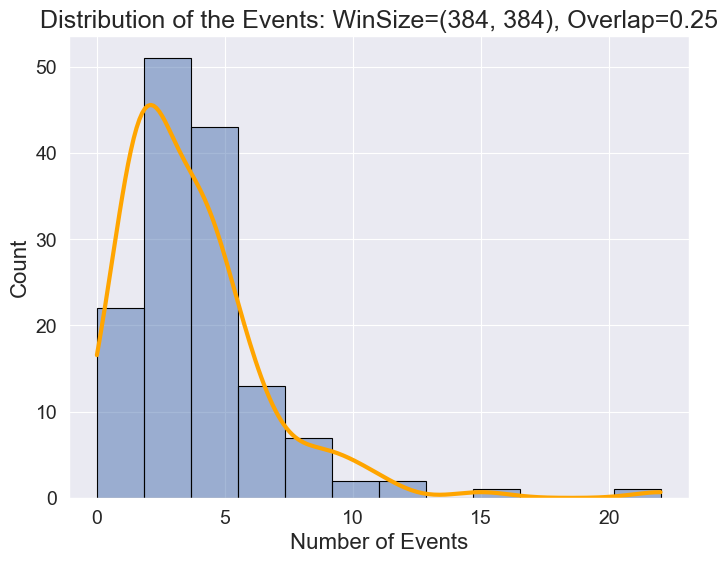

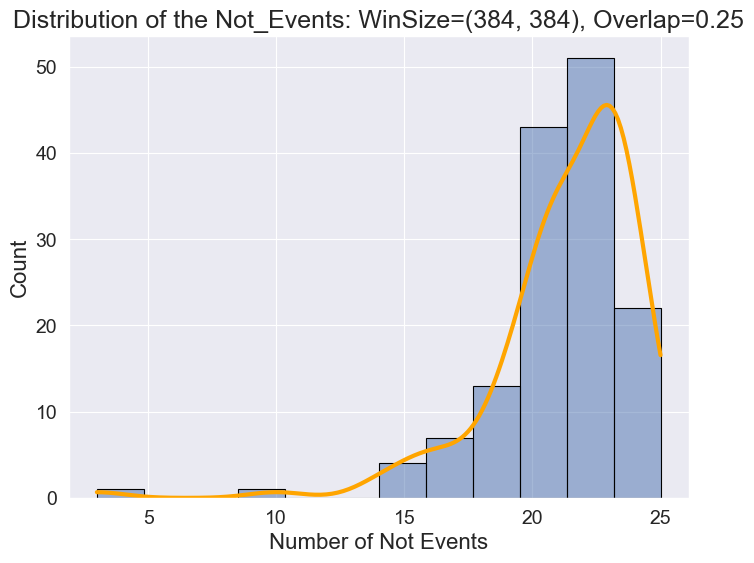

In [6]:
subfolders = list_subfolder('study_analysis')

idx = 0
for idx in range(len(subfolders)):

    subfolder_name = subfolders[idx].name
    additional_not_events = get_additional_not_events(subfolder_name)
    csv_concat = concat_csv(subfolders[idx])

    # sum events:
    sum_events = csv_concat['events'].sum()
    # sum not events:
    sum_not_events = csv_concat['not_events'].sum() + additional_not_events

    print('The number of events is: ', sum_events)
    print('The number of not events is: ', sum_not_events)
    ######## DICT ########
    im_size = literal_eval(subfolder_name.split('_')[2])
    overlap = literal_eval(subfolder_name.split('_')[4])
    window_size = literal_eval(subfolder_name.split('_')[-1])
    # create a dict with all the info:
    info = {'image_size': im_size, 'overlap': overlap, 'window_size': window_size, 'sum_events': sum_events, 'sum_not_events': sum_not_events}
    pd.to_pickle(info, f'study_dicts/{subfolder_name}.pkl')

    ######## PLOTTING ########
    # Setting the Seaborn theme and context
    sns.set_theme(style="darkgrid")
    sns.set_context("paper", font_scale=1.5)

    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))
    # Create the histplot
    ax = sns.histplot(data=csv_concat, x="events", bins=12, kde=True, edgecolor='black', line_kws={'linewidth': 3})
    ax.lines[0].set_color('orange')
    # Adding titles and labels
    ax.set_title(f'Distribution of the Events: WinSize={window_size}, Overlap={overlap}', fontsize=18)
    ax.set_xlabel('Number of Events', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)

    # Customizing ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # Save the figure
    fig.savefig(f'study_imgs/events_{subfolder_name}.png', dpi=400, bbox_inches='tight')
    # Show the plot
    plt.show()
    plt.close()
    ##############################################################################################
    # Create the figure and axis objects
    fig, ax = plt.subplots(figsize=(8, 6))
    # Create the histplot
    ax = sns.histplot(data=csv_concat, x="not_events", bins=12, kde=True, edgecolor='black', line_kws={'linewidth': 3})
    ax.lines[0].set_color('orange')
    # Adding titles and labels
    ax.set_title(f'Distribution of the Not_Events: WinSize={window_size}, Overlap={overlap}', fontsize=18)
    ax.set_xlabel('Number of Not Events', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)

    # Customizing ticks
    ax.tick_params(axis='both', which='major', labelsize=14)
    # Save the figure
    fig.savefig(f'study_imgs/notevents_{subfolder_name}.png', dpi=400, bbox_inches='tight')
    # Show the plot
    plt.show()
    plt.close()
    


In [12]:
# collect all pickle files:
dicts_path = [x for x in Path('study_dicts').iterdir() if x.is_file() and x.suffix == '.pkl']
info_dicts = [pd.read_pickle(x) for x in dicts_path]

# create a dataframe with all the info:
info_df = pd.DataFrame(info_dicts)

info_df['Proportion'] = info_df['sum_events'] / (info_df['sum_events'] + info_df['sum_not_events'])
# order by window size:
info_df.sort_values(by=['window_size'], inplace=True)

# now order by overlap:
info_df.sort_values(by=['overlap'], inplace=True)

# reset index:
info_df.reset_index(drop=True, inplace=True)
# remove column image_size:
info_df.drop(columns=['image_size'], inplace=True)

# bold the max value of columns: sum_events, sum_not_events, Proportion:
info_df.style.highlight_max(subset=['sum_events', 'sum_not_events', 'Proportion'], color='lightgreen', axis=0)

,overlap,window_size,sum_events,sum_not_events,Proportion
0,0.250000,"(128, 128)",1090,33335,0.031663
1,0.250000,"(256, 256)",581,6916,0.077498
2,0.250000,"(384, 384)",527,3298,0.137778
3,0.250000,"(512, 512)",541,1907,0.220997
4,0.330000,"(128, 128)",1211,37957,0.030918
5,0.330000,"(256, 256)",783,9009,0.079963
6,0.330000,"(384, 384)",527,3298,0.137778
7,0.330000,"(512, 512)",541,1907,0.220997
8,0.500000,"(128, 128)",2158,65315,0.031983
9,0.500000,"(256, 256)",1220,14080,0.079739
